In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras import Sequential, activations, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten,
    Conv2D, MaxPooling2D, SeparableConv2D
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Import project utils scripts
import os
import sys

src_path = os.path.abspath(os.path.join('../src/'))

if src_path not in sys.path:
    sys.path.append(src_path)


from convNetUtils import (
    predict_on_raster
)

from labelsUtils import (
    Label,
)

/home/simon/miniconda3/envs/earthEngine/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
from enum import Enum

class Band(Enum):
    COASTAL_AEROSOL = 0
    BLUE = 1
    GREEN = 2
    RED = 3
    NIR = 4
    SWIR1 = 5
    SWIR2 = 6
    TIRS1 = 7
    TIRS2 = 8
    NDVI = 9
    MNDWI = 10
    EVI2 = 11
    BU = 12

In [5]:
DATA_ROOT_PATH = '../data/'
MODEL_ROOT_PATH = '../models/'
IMAGE_SIZE = 9
BANDS = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

# Only labels that contains georeferenced points.
labels = [
    Label.COFFEE,
    Label.NATIVEVEGE,
    Label.RUBBER,
    Label.SEASONAL,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    # Label.CASSAVA, # /!\ only 4 images
    Label.TEA,
    Label.RICE,
    Label.INTERCROP,
    Label.DECIDUOUS_FOREST,
    Label.STICK_PEPPER,
    Label.PINE_TREES,
]

In [4]:
image_width = IMAGE_SIZE
image_height = IMAGE_SIZE
image_depth = len(BANDS)
nb_outputs = len(labels)

model = Sequential([
    Rescaling(1./2**16, input_shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

model.summary()
model.load_weights(MODEL_ROOT_PATH + "january_to_april_2017_every_labels.hdf5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 9, 9, 7)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 7)           28        
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 9, 32)          2048      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          3

In [8]:
year_predictions = []
year_img_indices = []

for year in range(14, 22):
    print(f"20{year} :\n-------")

    raster_path = DATA_ROOT_PATH + "Vietnam_20{}_january_to_april/merged.tif".format(year)
    predictions, img_indices = predict_on_raster(model, raster_path, BANDS, IMAGE_SIZE)
    
    for label in labels:
        nb_occurences = predictions.count(labels.index(label))
        print(f"{label.name} count : {nb_occurences}")
    
    year_predictions.append(predictions)
    year_img_indices.append(img_indices)

2014 :
-------
Image width: 16709
Image height: 7423
Nb row of images: 1856
Nb col of images: 824
Width is not dividable by 9, some px will be ignored...
Height is not dividable by 9, some px will be ignored...
COFFEE count : 62323
NATIVEVEGE count : 229031
RUBBER count : 76087
SEASONAL count : 67700
URBAN count : 66589
WATER count : 51328
OTHER_TREE count : 222131
NATIVE_NO_TREE count : 35287
PEPPER count : 48856
TEA count : 19392
RICE count : 206518
INTERCROP count : 650
DECIDUOUS_FOREST count : 77824
STICK_PEPPER count : 4415
PINE_TREES count : 32229
2015 :
-------
Image width: 16709
Image height: 7423
Nb row of images: 1856
Nb col of images: 824
Width is not dividable by 9, some px will be ignored...
Height is not dividable by 9, some px will be ignored...
COFFEE count : 62527
NATIVEVEGE count : 191309
RUBBER count : 75379
SEASONAL count : 99236
URBAN count : 82742
WATER count : 49565
OTHER_TREE count : 213138
NATIVE_NO_TREE count : 46111
PEPPER count : 46972
TEA count : 15349
RICE

In [225]:
# year_predictions = [
#     [labels[prediction].name for prediction in year_predictions[year]]
#     for year in range(len(year_predictions))
# ]

row_indices = [
    [indices[0] for indices in year_img_indices[year]]
    for year in range(len(year_predictions))
]

col_indices = [
    [indices[1] for indices in year_img_indices[year]]
    for year in range(len(year_predictions))
] 

df_list = [
    pd.DataFrame(data={
        'image row': row_indices[year - 14],
        'image col': col_indices[year - 14],
        'predicted': year_predictions[year - 14]
    }).assign(year=int("20" + str(year)))
    for year in range(14, 22)
]

# Concatenate all those dataframe into one
concat_df = pd.concat(df_list)

In [226]:
concat_df.to_csv(os.path.join(DATA_ROOT_PATH, 'predictions_january_to_april_2014_2021.csv'), index=False)

In [11]:
concat_df = pd.read_csv(os.path.join(DATA_ROOT_PATH, 'predictions_january_to_april_2014_2021.csv'))

In [13]:
concat_df

,image row,image col,predicted,year
0,0,358,OTHER_TREE,2014
1,0,359,OTHER_TREE,2014
2,0,360,OTHER_TREE,2014
3,0,361,NATIVEVEGE,2014
4,0,362,OTHER_TREE,2014
...,...,...,...,...
9581157,1855,253,RICE,2021
9581158,1855,254,TEA,2021
9581159,1855,255,RUBBER,2021
9581160,1855,256,NATIVEVEGE,2021


In [14]:
total_per_year_df = concat_df.groupby('year').agg(count=pd.NamedAgg(column='predicted', aggfunc='value_counts')).reset_index()

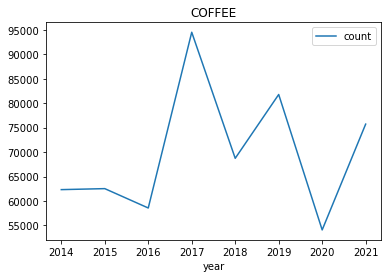

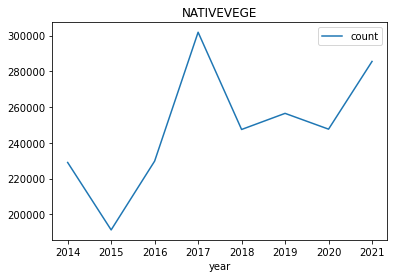

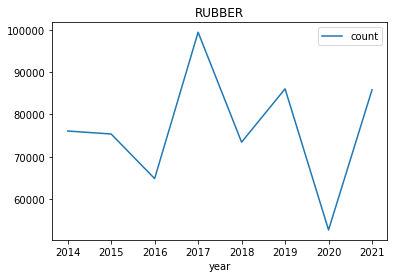

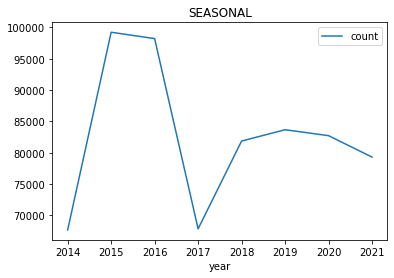

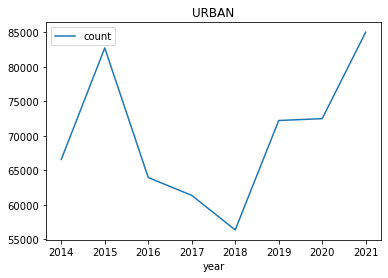

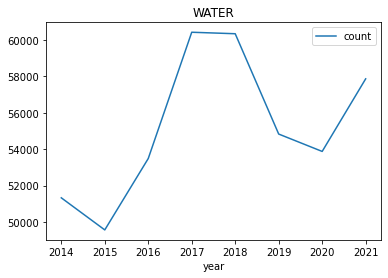

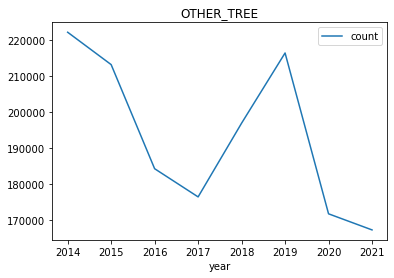

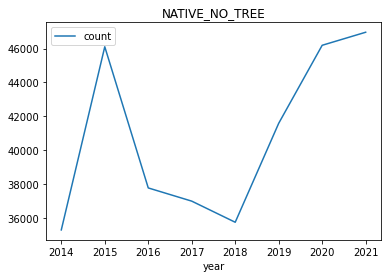

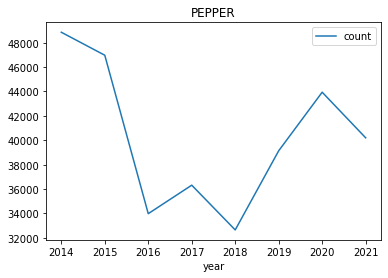

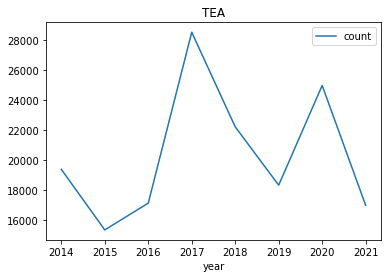

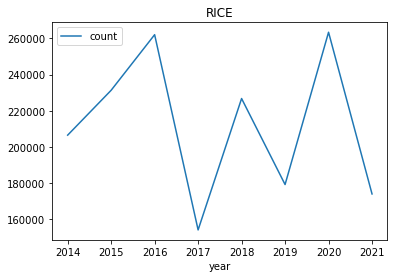

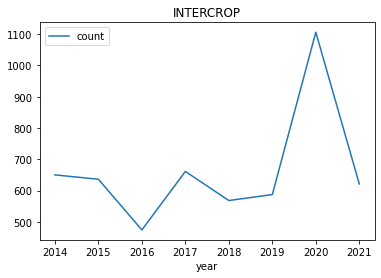

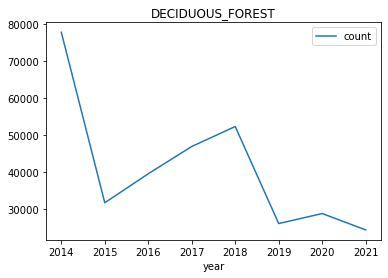

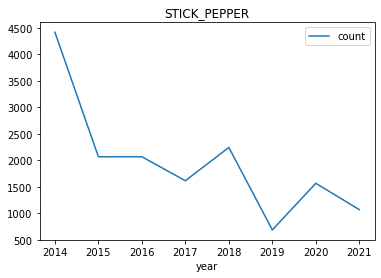

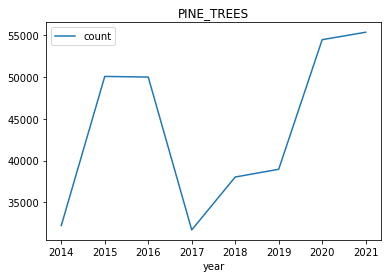

In [242]:
for label in labels:
    total_per_year_df[total_per_year_df['predicted']==label.name][['count', 'year']].plot(x="year", title=label.name)